<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/two_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install transformers==2.3.0

In [68]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from google.colab import drive

from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertModel   #BERT
from tensorflow.keras.layers import Dense, Flatten

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [69]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -uq "/content/drive/MyDrive/AIFFEL/sns_train.zip" -d "/content/sns_data"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFFEL/train/train.csv")

In [6]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [70]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [8]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [71]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

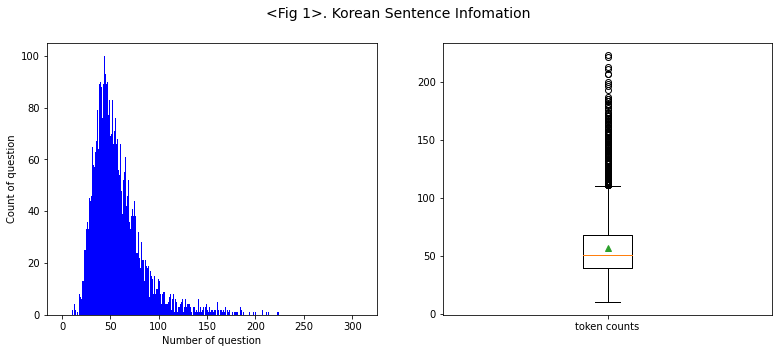

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [10]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [11]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv']

In [12]:

df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])


In [13]:
df_all["class"] = "일반 대화"

In [14]:
df_all.head()

,0,class
0,아니 나도 이제야 목이아프기시작햇어 침삼키는게 왜케아프죸ㅋㅋㅋㅋㅋㅋㅋ\n나듀 난 이...,일반 대화
1,배아퍼서 화장실왓는데 ㄷ우너유ㅠㅠ\n헐랭 배아포? ㅠㅠ\n웅 어제 계속 매운거만 먹...,일반 대화
2,나 요번주 금욜에 인생 최초로 위내시경 한다\n오우 함 해야해....! 화이또야 혼...,일반 대화
3,자거일어남ㄴ 왤케 담이 심해질따 까\n잘때 어찌자노\n편하게...자눈데...\n너무...,일반 대화
4,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ운동이고 뭐고 이불 속이 최고시더\n나두 운동해야될것같은데 ㅠㅠ...,일반 대화


In [15]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [16]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,아니 나도 이제야 목이아프기시작햇어 침삼키는게 왜케아프죸ㅋㅋㅋㅋㅋㅋㅋ\n나듀 난 이...
1,일반 대화,배아퍼서 화장실왓는데 ㄷ우너유ㅠㅠ\n헐랭 배아포? ㅠㅠ\n웅 어제 계속 매운거만 먹...
2,일반 대화,나 요번주 금욜에 인생 최초로 위내시경 한다\n오우 함 해야해....! 화이또야 혼...
3,일반 대화,자거일어남ㄴ 왤케 담이 심해질따 까\n잘때 어찌자노\n편하게...자눈데...\n너무...
4,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ운동이고 뭐고 이불 속이 최고시더\n나두 운동해야될것같은데 ㅠㅠ...
...,...,...
511550,일반 대화,안뇽여봉~~♡\n여보안뇽~~ 셤보러가는거야~?\n웅ㅋㅋㅋ 도착했어ㅜ #@이모티콘#\...
511551,일반 대화,째릿\n!!! 고기 구워먹는것도 #@이름#이도\n어니 친구들이랑 노는거\n아하 맨날...
511552,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋ 웅웅 여보 오후도 회니팅이얌!!!!\n여보도 오후 잘하고있나아 밖에...
511553,일반 대화,생각도 다이어트가 필요하다잖아 내가 그런 타입인듯 ㅋㅋㅋㅋ\n나도 그래 근데 감정적...


In [17]:
df_train2 = df_all.sample(n = 4000, random_state = 6)

In [18]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
72794,일반 대화,장혁 이규형 과연 니가 누구를 고를지 궁금하다 거의 얼굴이랑 피지컬만 보고있다 에이...
391598,일반 대화,그뭐냐 쿨라임인지먼지 그거도 좀남았는데 보내줘 좀남은건 머야 시스템 사진 보내주고싶...
494193,일반 대화,이름 이가 불끄고 충전해주고 갔나봐 오옹 착한 동생 아 치킨은 줬어 웅웅 맛있다고 ...
10136,일반 대화,시스템 사진 이렇게 말씀드릴라고 우와 쩐다 충전기 나도 살 수 있어 웅 너도 너도 ...
94112,일반 대화,얼마나 휴가냈내 일단 3일 근육이 펑 터지는 소리남 신기하더라 안아픔 기타 아파 못...
...,...,...
80025,일반 대화,아니 이름 이는 25살쯤같아 28은 안어울려 끄치 나도 내가 계쏙 20 초중반같아 ...
136256,일반 대화,시스템 사진 감자스파 감자고로케 감자샐러드 만드느라 초토화 하는데 힘들고 치우는데 ...
27563,일반 대화,8시에 도착 보문산입구에서 만나는거여 개웃겨 보문산입구개 그 오거리쪽 우웅웅 거기 ...
178302,일반 대화,갑자기웬냉면 그냥 그때 너랑 얘기하지 않았나 육쌈냉면 땡긴다고 아 그건맞아 뭐야 이...


In [19]:
df_train2.to_csv("/content/drive/MyDrive/AIFFEL/sns_4000.csv")

In [20]:
df_train2.describe()

,class,conversation
count,4000,4000
unique,1,4000
top,일반 대화,장혁 이규형 과연 니가 누구를 고를지 궁금하다 거의 얼굴이랑 피지컬만 보고있다 에이...
freq,4000,1


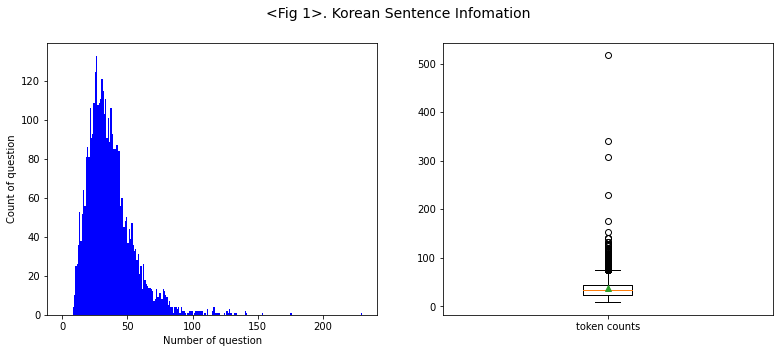

=========================================< Sentence Info >==========================================
길이 최대:     517
길이 최소:       8
길이 평균:     36.804
길이 표준편차:  20.761

 25/100분위:   24.000
 50/100분위:   33.000
 75/100분위:   44.000
 MAX/100분위:  74.000
 IQR:  20.000


In [21]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [22]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
80025,NaN,일반 대화,아니 이름 이는 25살쯤같아 28은 안어울려 끄치 나도 내가 계쏙 20 초중반같아 ...
136256,NaN,일반 대화,시스템 사진 감자스파 감자고로케 감자샐러드 만드느라 초토화 하는데 힘들고 치우는데 ...
27563,NaN,일반 대화,8시에 도착 보문산입구에서 만나는거여 개웃겨 보문산입구개 그 오거리쪽 우웅웅 거기 ...
178302,NaN,일반 대화,갑자기웬냉면 그냥 그때 너랑 얘기하지 않았나 육쌈냉면 땡긴다고 아 그건맞아 뭐야 이...


In [23]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
80025,일반 대화,아니 이름 이는 25살쯤같아 28은 안어울려 끄치 나도 내가 계쏙 20 초중반같아 ...
136256,일반 대화,시스템 사진 감자스파 감자고로케 감자샐러드 만드느라 초토화 하는데 힘들고 치우는데 ...
27563,일반 대화,8시에 도착 보문산입구에서 만나는거여 개웃겨 보문산입구개 그 오거리쪽 우웅웅 거기 ...
178302,일반 대화,갑자기웬냉면 그냥 그때 너랑 얘기하지 않았나 육쌈냉면 땡긴다고 아 그건맞아 뭐야 이...


In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,일반 대화,융융 어차피 말해봤자 상황바뀌는거없고 그치 내가아침마다 아빠 밥차려주는거 똑같고 주...
1,기타 괴롭힘 대화,저 허우적 거리는것봐 야 너 지팡이 없으면 못 걸어다니지 그건 아닌데 없으면 불편하...
2,기타 괴롭힘 대화,야 너 진짜 못생긴거 알아 니가 뭔데 그런 말을 하는거야 아니 너 거울 좀 봐 싫어...
3,일반 대화,가성비에서 퀄리티 좀만 업 기기 깃도 큰건 아니어서 막 정장핏도 아닌것같아서 좋아 ...
4,갈취 대화,어머님 지금 뭐하시는 거에요 아가 너 다짜고짜 그게 무슨 말이니 어머님이 저희 엄마...
...,...,...
7945,기타 괴롭힘 대화,이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 ...
7946,일반 대화,라우오어으오아오여고요어고어고여거도여더여가고력 너 집 가기만햐 나 팬티까지 다 챙겨옴...
7947,직장 내 괴롭힘 대화,저기 신입은 남자친구있어 아 없는데요 그럼 저기 과장님어때 네 저보다 20살 많으시...
7948,갈취 대화,민주야 그거 입술에 바른거뭐야 아 이번에 로드샵에서 신상인데 세일할때 삿어 근데 너...


In [136]:
df = pd.read_csv("/content/drive/MyDrive/AIFFEL/senti_kor_sns_5000_bt.csv")
df.head()

,Unnamed: 0,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


협박 대화           3584
갈취 대화           3924
직장 내 괴롭힘 대화     3916
기타 괴롭힘 대화       4376
일반 대화          15346
Name: Unnamed: 0, dtype: int64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_

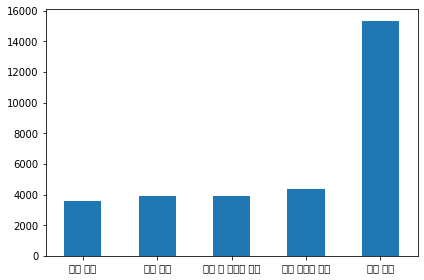

In [137]:
group_count = df.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

In [138]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df["class"]):
  if label == 0:
    bucket_class.append(label_names[0])
  elif label == 1:
    bucket_class.append(label_names[1])
  elif label == 2:
    bucket_class.append(label_names[2])
  elif label == 3:
    bucket_class.append(label_names[3])
  elif label == 4:
    bucket_class.append(label_names[4])

df["class"] = bucket_class
df.head()

,Unnamed: 0,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [140]:
bucket_class.count("일반 대화")

15346

In [141]:
df_train = df

In [142]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 128)

In [143]:
df_train["협박 대화"] = int(0)
df_train["갈취 대화"] = int(0)
df_train["직장 내 괴롭힘 대화"] = int(0)
df_train["기타 괴롭힘 대화"] = int(0)
df_train["일반 대화"] = int(0)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,0,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,0,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,0,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,0,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,0,0,0,0


In [144]:
for idx, label in enumerate(df_train["class"]):
    if label == "협박 대화":
        df_train.loc[idx, "협박 대화"] = int(1)
    elif label == "갈취 대화":
        df_train.loc[idx, "갈취 대화"] = int(1)
    elif label == "직장 내 괴롭힘 대화":
        df_train.loc[idx, "직장 내 괴롭힘 대화"] = int(1)
    elif label == "기타 괴롭힘 대화":
        df_train.loc[idx, "기타 괴롭힘 대화"] = int(1)
    elif label == "일반 대화":
        df_train.loc[idx, "일반 대화"] = int(1)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0


In [145]:
df_train

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0
...,...,...,...,...,...,...,...,...
31141,31141,기타 괴롭힘 대화,"준샤, 왜 이렇게 큰 거야? 내 머릿속에 뭐가 들어있어? 큰 사람이라고 말하지 않았...",0,0,0,1,0
31142,31142,갈취 대화,"내가 지금 당신 아들을 데리고 있다면, 당신이 그를 구하려고 하면, 그냥 돈을 보내...",0,1,0,0,0
31143,31143,직장 내 괴롭힘 대화,당신 같은 사람을 보면 어떻게 이렇게 살 수 있을까요? 왜 그렇게 말하는 거죠? 지...,0,0,1,0,0
31144,31144,갈취 대화,"여기서 무슨 일을 하든 경찰에 신고하고 정식으로 사업을 해야 하는데, 어디든 우리 ...",0,1,0,0,0


In [154]:
a = df_train["class"].to_list
type(a)

method

In [85]:
model_name = 'bert-base-uncased'

In [86]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['conversation'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

100%|██████████| 31146/31146 [01:12<00:00, 429.90it/s]


In [87]:
labels =  df_train[label_names].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [89]:
BATCH_SIZE = 16
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [90]:
class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(model_name), len(label_names))

In [91]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_names))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_names))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_names):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_names):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 1/1751 [00:17<8:30:56, 17.52s/it]


Train Step: 0, Loss: 0.609353244304657
협박 대화 roc_auc 0.8214285373687744
갈취 대화 roc_auc 0.9333332777023315
직장 내 괴롭힘 대화 roc_auc 0.6153846979141235
기타 괴롭힘 대화 roc_auc 0.3333333134651184
일반 대화 roc_auc 0.5476190447807312


 57%|█████▋    | 1001/1751 [04:30<03:16,  3.82it/s]


Train Step: 1000, Loss: 0.3018667697906494
협박 대화 roc_auc 0.8076704740524292
갈취 대화 roc_auc 0.8206968903541565
직장 내 괴롭힘 대화 roc_auc 0.813718318939209
기타 괴롭힘 대화 roc_auc 0.7852821350097656
일반 대화 roc_auc 0.9487107992172241


1752it [07:52,  3.71it/s]
195it [00:20,  9.53it/s]


Epoch 1, Validation Loss: 0.21319349110126495, Time: 492.79000997543335

협박 대화 roc_auc 0.8905760645866394
갈취 대화 roc_auc 0.9163194298744202
직장 내 괴롭힘 대화 roc_auc 0.9415153861045837
기타 괴롭힘 대화 roc_auc 0.8727274537086487
일반 대화 roc_auc 0.9901632070541382




In [92]:
json_path = "/content/drive/MyDrive/AIFFEL/test/test.json"

df_test = pd.read_json(json_path, orient ='index')

In [93]:
df_test.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [94]:
test_input_ids = tokenize_sentences(df_test['text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

100%|██████████| 500/500 [00:01<00:00, 364.09it/s]


In [106]:
TEST_BATCH_SIZE = 16
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

In [107]:
pred = model.predict(test_dataset)

In [108]:
pred = np.argmax(pred, axis = -1)

In [112]:
pred_list = list(pred)
pred_list

[3,
 2,
 4,
 4,
 4,
 2,
 3,
 1,
 4,
 1,
 2,
 4,
 2,
 2,
 2,
 3,
 4,
 4,
 0,
 3,
 0,
 3,
 3,
 1,
 1,
 2,
 4,
 4,
 4,
 4,
 1,
 1,
 3,
 1,
 4,
 1,
 3,
 1,
 0,
 1,
 4,
 1,
 1,
 3,
 3,
 2,
 3,
 0,
 4,
 3,
 4,
 3,
 1,
 2,
 2,
 2,
 4,
 3,
 3,
 3,
 1,
 4,
 2,
 3,
 2,
 0,
 4,
 4,
 4,
 1,
 4,
 2,
 4,
 2,
 2,
 4,
 4,
 4,
 2,
 4,
 0,
 3,
 4,
 0,
 3,
 4,
 0,
 4,
 4,
 2,
 2,
 2,
 3,
 4,
 4,
 2,
 4,
 2,
 1,
 2,
 4,
 1,
 4,
 2,
 3,
 2,
 2,
 3,
 4,
 1,
 4,
 0,
 2,
 2,
 2,
 1,
 4,
 4,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 2,
 3,
 2,
 4,
 3,
 3,
 1,
 0,
 4,
 0,
 4,
 4,
 0,
 4,
 1,
 3,
 4,
 0,
 3,
 3,
 0,
 1,
 2,
 3,
 4,
 4,
 4,
 4,
 1,
 2,
 4,
 3,
 3,
 3,
 4,
 1,
 4,
 4,
 2,
 4,
 4,
 4,
 3,
 2,
 2,
 1,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 3,
 0,
 3,
 1,
 1,
 1,
 3,
 3,
 4,
 0,
 0,
 2,
 4,
 3,
 4,
 3,
 4,
 2,
 2,
 2,
 2,
 4,
 1,
 2,
 2,
 1,
 4,
 4,
 4,
 3,
 3,
 1,
 2,
 3,
 4,
 4,
 4,
 4,
 3,
 1,
 1,
 2,
 3,
 4,
 3,
 1,
 3,
 3,
 1,
 3,
 3,
 3,
 4,
 3,
 2,
 4,
 1,
 2,
 4,
 4,
 4,


In [110]:
pred_list.count(4)

149